In [32]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [33]:
max_degree = 20 #多项式的最大阶数
n_train,n_test = 100,100 #训练和测试数据集大小
true_w = np.zeros(max_degree) #分配大量的空间

true_w[0:4] = np.array([5,1.2,-3.4,5.6])
print(true_w)
features = np.random.normal(size=(n_train + n_test,1)) #随机初始化？
# print(features)
np.random.shuffle(features)
# print(features)
poly_features = np.power(features,np.arange(max_degree).reshape(1,-1))
print(poly_features)
for i in range(max_degree):
    poly_features[:,1] /= math.gamma(i+1) #gamma(n)=(n-1)!

#labels的维度：(n_train+n_test)
labels = np.dot(poly_features,true_w)
labels += np.random.normal(scale=0.1,size=labels.shape)

[ 5.   1.2 -3.4  5.6  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0. ]
[[ 1.00000000e+00 -1.65237171e+00  2.73033227e+00 ... -5.10307281e+03
   8.43217315e+03 -1.39330844e+04]
 [ 1.00000000e+00 -2.35216074e-01  5.53266017e-02 ... -2.06508989e-11
   4.85742337e-12 -1.14254406e-12]
 [ 1.00000000e+00 -2.62816501e-01  6.90725129e-02 ... -1.36174152e-10
   3.57888141e-11 -9.40589088e-12]
 ...
 [ 1.00000000e+00 -1.98195857e+00  3.92815979e+00 ... -1.12358966e+05
   2.22690817e+05 -4.41363973e+05]
 [ 1.00000000e+00  1.18615856e-01  1.40697213e-02 ...  1.82148965e-16
   2.16057554e-17  2.56278517e-18]
 [ 1.00000000e+00 -6.75153540e-01  4.55832302e-01 ... -1.25847134e-03
   8.49661382e-04 -5.73651889e-04]]


In [34]:
true_w,features,poly_features,labels = [torch.tensor(x,dtype=torch.float32) for x in [true_w,features,poly_features,labels]]
features[:2],poly_features[:2,:],labels[:2]

(tensor([[-1.6524],
         [-0.2352]]),
 tensor([[ 1.0000e+00, -0.0000e+00,  2.7303e+00, -4.5115e+00,  7.4547e+00,
          -1.2318e+01,  2.0354e+01, -3.3632e+01,  5.5573e+01, -9.1827e+01,
           1.5173e+02, -2.5072e+02,  4.1428e+02, -6.8454e+02,  1.1311e+03,
          -1.8690e+03,  3.0883e+03, -5.1031e+03,  8.4322e+03, -1.3933e+04],
         [ 1.0000e+00, -0.0000e+00,  5.5327e-02, -1.3014e-02,  3.0610e-03,
          -7.2000e-04,  1.6936e-04, -3.9835e-05,  9.3699e-06, -2.2040e-06,
           5.1841e-07, -1.2194e-07,  2.8682e-08, -6.7464e-09,  1.5869e-09,
          -3.7325e-10,  8.7795e-11, -2.0651e-11,  4.8574e-12, -1.1425e-12]]),
 tensor([-29.6771,   4.7816]))

In [35]:
def evaluate_loss(net,data_iter,loss): #@save
    '''评估给定数据集上模型的损失'''
    metric = d2l.Accumulator(2) #损失的总和，样本数量
    for X,y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out,y)
        metric.add(l.sum(),l.numel())
    return metric[0] / metric[1]

In [36]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 0],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

## 三阶多项式函数拟合（正常）

weight: [[ 4.9943104 -0.4692763 -3.4081373  5.6004505]]


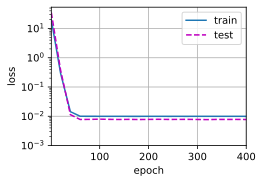

In [37]:
#从多项式选择前四个维度
train(poly_features[:n_train,:4],poly_features[n_train:,:4],labels[:n_train],labels[n_train:])

## 欠拟合

weight: [[ 2.2501276  -0.44085106]]


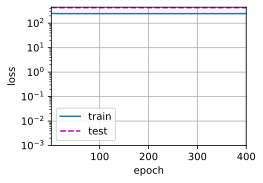

In [38]:
#从多项式选择前两个维度
train(poly_features[:n_train,:2],poly_features[n_train:,:2],labels[:n_train],labels[n_train:])

## 过拟合

weight: [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]]


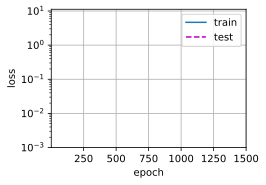

In [40]:
#从多项式选择前所有维度
train(poly_features[:n_train,:],poly_features[n_train:,:],labels[:n_train],labels[n_train:],num_epochs=1500)